# Logistic Regression


# Model
<h3>prior</h3>

$\theta \sim Normal( \mathbf{m},\Sigma)$ 

<h3>likelihood</h3>

$samples - Bernoulli(\theta^T\mathbf{x})$

In [2]:
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd
import jax
key = jax.random.PRNGKey(0)
import logging
import pickle
import blackjax
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-06 18:53:14.713221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [21]:
uniform = tfd.Uniform(-30,30)
m = 1000
n = 2
x = uniform.sample(seed=key,sample_shape=(m,n)).reshape((m,n))

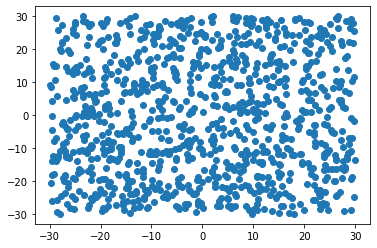

In [22]:
plt.scatter(x[:,0],x[:,1])

In [23]:
theta = jnp.array([[2.0,-1.0,2]]).T
theta 

DeviceArray([[ 2.],
             [-1.],
             [ 2.]], dtype=float32)

In [24]:
x = jnp.append(x,jnp.ones((x.shape[0],1)),axis=1)
bern = tfd.Bernoulli(x@theta)

In [25]:
y = bern.sample(sample_shape=1,seed=key)
y.shape

(1, 1000, 1)

In [26]:
bern.log_prob(y)[0,:,0]

DeviceArray([-2.98016656e-09, -2.83621962e-24, -1.16504421e-31,
             -1.46479815e-08, -1.41201953e-10, -1.56893232e-03,
             -3.93576307e-17, -1.05333738e-05, -1.68265390e-19,
             -8.15814312e-33, -6.05065957e-22, -5.39593869e-14,
             -6.94368006e-15, -1.36895720e-14, -2.64244564e-02,
             -1.53876041e-22, -1.94998956e-22, -6.70246591e-05,
             -1.82274170e-02, -1.92363558e-07, -9.71124141e-24,
             -8.10696132e-09, -1.09561677e-35, -4.45702019e-22,
             -2.34059476e-33, -3.67415311e-23, -1.72384884e-02,
             -3.40707623e-03, -1.56861842e-01, -8.03551992e-19,
             -8.06953333e-17, -3.10875679e-04, -2.81241315e-14,
             -2.97011041e-32, -1.73077397e-15, -1.88437139e-06,
             -1.34183402e-14, -5.43908113e-32, -3.24484072e-31,
             -1.00753095e-09, -7.87577169e-19, -2.17608058e-18,
             -3.75716738e-08, -1.50689953e-13, -3.27352294e-16,
             -5.15123859e-21, -6.6390541

In [27]:
jnp.sum(y[:]==1)

DeviceArray(511, dtype=int32)

In [28]:
one = y[:]==1


In [29]:
x.shape

(1000, 3)

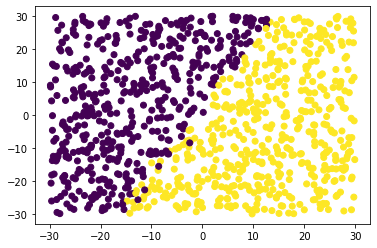

In [30]:
# plt.scatter(x[one][:,0],x[one][:,1])
# plt.scatter(x[~one][:,0],x[~one][:,1],c='r')
plt.scatter(x[:,0],x[:,1],c=y)
plt.savefig("")

In [32]:
prior_mean = jnp.array([1.9,5.9,5])
prior_var = 5*jnp.identity(3)
prior_normal = tfd.MultivariateNormalFullCovariance(
    loc= prior_mean,covariance_matrix=prior_var
)
n = n+1

In [33]:
import pickle
dictionary = {
    "data":{"x":x,"y":y},
    'prior':{'loc':prior_mean,'covariance_matrix':prior_var}
    }
with open("coin_toss_data",'wb') as f:
    pickle.dump(dictionary,f)

In [34]:
y.reshape((1, m, 1))
def log_postfn(theta):
    log_prior = prior_normal.log_prob(theta)
    logit = (x@theta.reshape(n,1))
    likelihood_bern = tfd.Bernoulli(logit)
    log_like = jnp.sum(likelihood_bern.log_prob(y)[0,:,0])
    return (log_like+log_prior)
log_postfn(jnp.array([10.4, 11.4,2.4]))



DeviceArray(-74796.74, dtype=float32)

In [35]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [37]:
rmh = blackjax.rmh(log_postfn, sigma=jnp.identity(n) * 0.8)
initial = jnp.array(jnp.array([12,1.0,12.0]))
initial_state = rmh.init(initial)
initial_state

RMHState(position=DeviceArray([12.,  1., 12.], dtype=float32), log_probability=DeviceArray(-13018.695, dtype=float32))

In [38]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

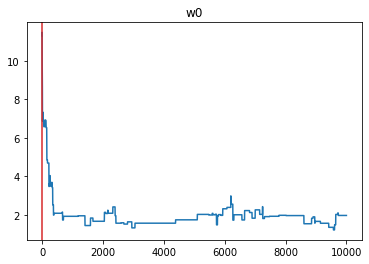

In [39]:
burnin = 0
fig, ax = plt.subplots()
ax.plot(states.position[:,0])
ax.set_title(f"w0")
ax.axvline(x=burnin, c="tab:red")
plt.show()

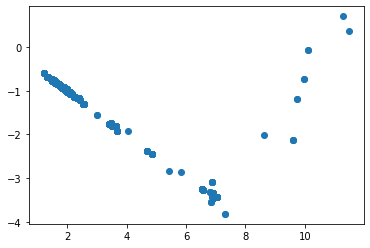

In [40]:
plt.scatter(states.position[burnin:,0],states.position[burnin:,1])

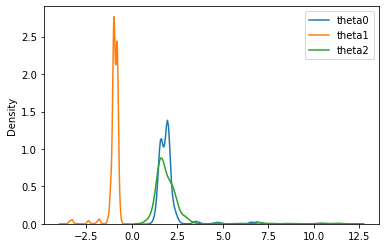

In [42]:
sns.kdeplot(states.position[burnin:,0],label="theta0")
sns.kdeplot(states.position[burnin:,1],label="theta1")
sns.kdeplot(states.position[burnin:,2],label="theta2")
plt.legend()
plt.show()